# [Blackjack](https://github.com/SUTD-MARL/reinforcement-learning-exercises/blob/master/MC/Blackjack%20Playground.ipynb)

In [11]:
import numpy as np
import os, sys
import pprint
pp = pprint.PrettyPrinter(indent=2)
from collections import defaultdict

sys.path.insert(
    1,
    os.path.realpath(
        os.path.join(os.path.pardir, "reinforcement-learning-exercises")
    )
)

from lib.envs.blackjack import BlackjackEnv
from lib import plotting
import matplotlib
matplotlib.style.use('ggplot')

In [12]:
env = BlackjackEnv()

In [18]:
def sample_policy(observation):
    """
    A policy that sticks if the player score is > 20 and hits otherwise.
    """
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1

In [19]:
def mc_prediction(policy, env, num_episodes, discount_factor=1.0):
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    V = defaultdict(float)
    
    for episode in range(num_episodes):
        rewards = []
        observation = env.reset()
        observations = [observation]
        
        # Generate
        for t in range(100):
            action = policy(observation)
            observation, reward, done, _ = env.step(action)
            rewards += [reward]
            if done:
                break
            else:
                observations += [observation]
                
        # Estimate
        G = 0
        for step in reversed(range(len(observations))):
            observation = observations[step]
            reward = rewards[step]
            G = discount_factor * G + reward
            if not observation in observations[:step]:
                returns_sum[observation] += G
                returns_count[observation] += 1.0
                
    # Value function
    for observation in returns_sum:
        V[observation] = returns_sum[observation] / returns_count[observation]
        
    return V

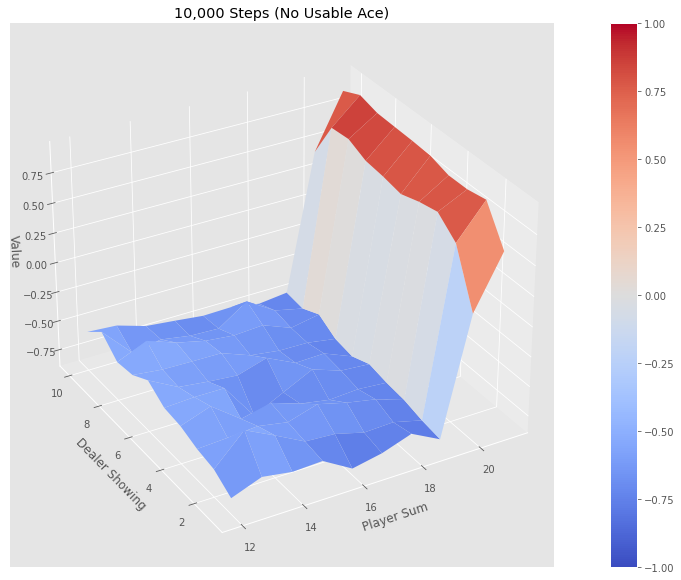

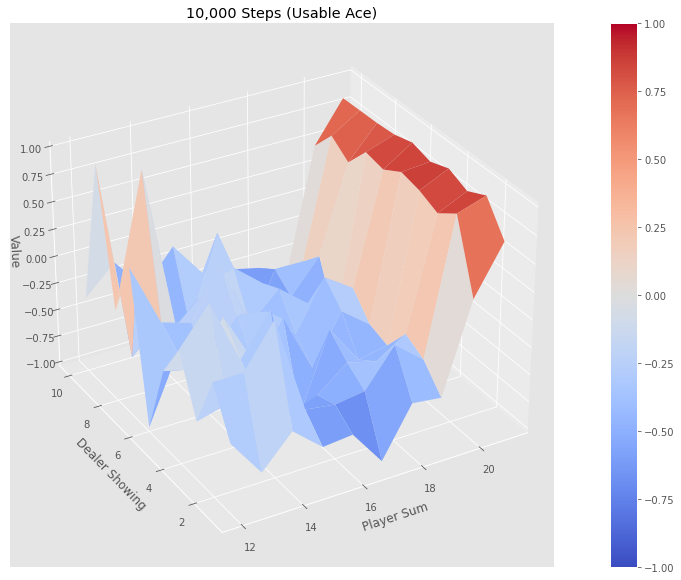

In [22]:
V_10k = mc_prediction(sample_policy, env, num_episodes=10000)
plotting.plot_value_function(V_10k, title="10,000 Steps")

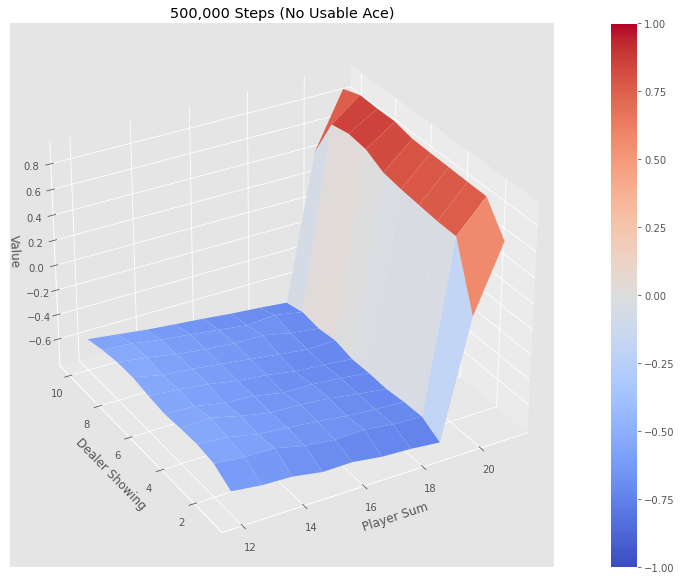

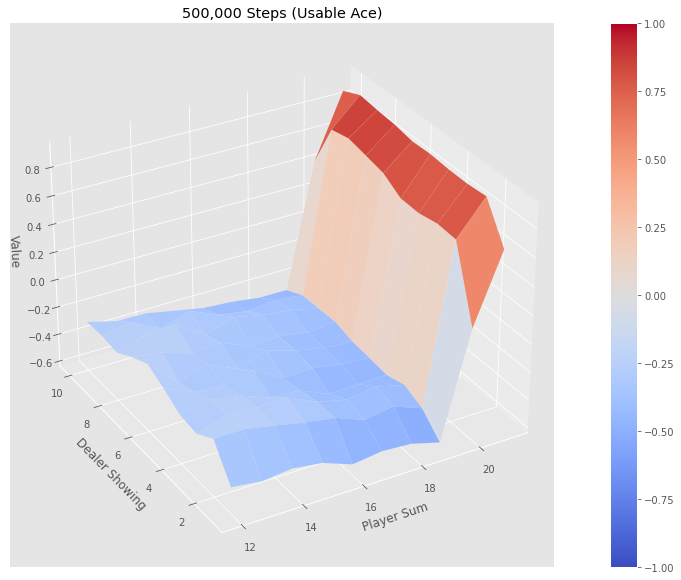

In [23]:
V_500k = mc_prediction(sample_policy, env, num_episodes=500000)
plotting.plot_value_function(V_500k, title="500,000 Steps")

## On-policy Monte Carlo methods with $\epsilon$-greedy policies

In [47]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        best_value = np.amax(Q[observation])
        best_action = list(Q[observation]).index(best_value)
        probs = np.ones(nA) * epsilon / nA
        probs[best_action] = 1 - epsilon + epsilon / nA
        return probs
    
    return policy_fn

In [50]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=0.1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for episode in range(num_episodes):
        
        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
            
        rewards = []
        observation = env.reset()
        trace = []
        
        # Generate
        for t in range(100):
            probs = policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            trace += [(observation, action)]
            observation, reward, done, _ = env.step(action)
            rewards += [reward]
            if done:
                break
                
        # Estimate
        G = 0
        for step in reversed(range(len(trace))):
            observation, action = trace[step]
            reward = rewards[step]
            G = discount_factor * G + reward
            if not (observation, action) in trace[:step]:
                returns_sum[(observation, action)] += G
                returns_count[(observation, action)] += 1.0
            Q[observation][action] = returns_sum[(observation, action)] / returns_count[(observation, action)]
                
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    return Q, policy

In [52]:
Q, policy = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=0.1)

Episode 499000/500000.

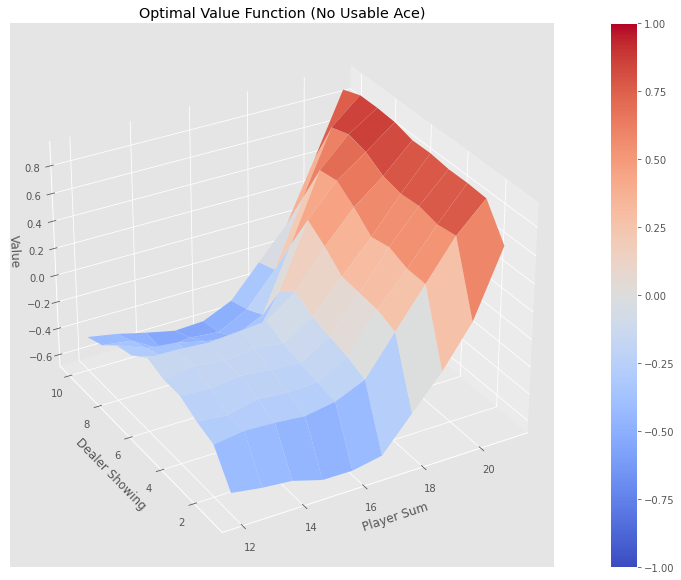

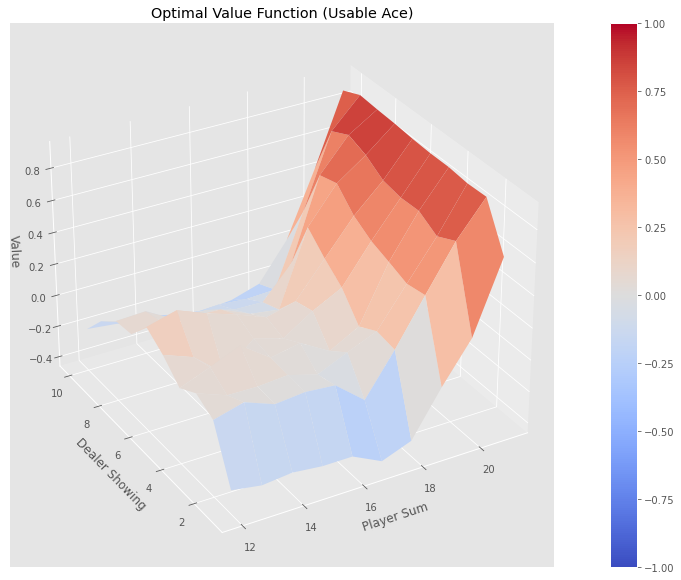

In [51]:
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")

## Off-policy Monte Carlo control with weighted importance sampling

In [53]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [57]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation): 
        best_action = np.argmax(Q[observation])
        probs = np.zeros(len(Q[observation]), dtype=float)
        probs[best_action] = 1.0
        return probs
    
    return policy_fn

In [58]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    weights = defaultdict(float)
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    
    for episode in range(num_episodes+1):
        
        if episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(episode, num_episodes), end="")
            sys.stdout.flush()
            
        rewards = []
        observation = env.reset()
        trace = []
        
        # Generate
        for t in range(100):
            probs = behavior_policy(observation)
            action = np.random.choice(np.arange(len(probs)), p=probs)
            trace += [(observation, action)]
            observation, reward, done, _ = env.step(action)
            rewards += [reward]
            if done:
                break
                
        # Estimate
        G = 0.0
        W = 1.0
        for step in reversed(range(len(trace))):
            observation, action = trace[step]
            reward = rewards[step]
            G = discount_factor * G + reward
            weights[(observation, action)] += W
            Q[observation][action] += W / weights[(observation, action)] * (G - Q[observation][action])
            target_policy = create_greedy_policy(Q)
            if action != np.argmax(target_policy(observation)):
                break
            W = W * 1.0 / behavior_policy(observation)[action]
                        
    return Q, target_policy

In [59]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

Episode 500000/500000.

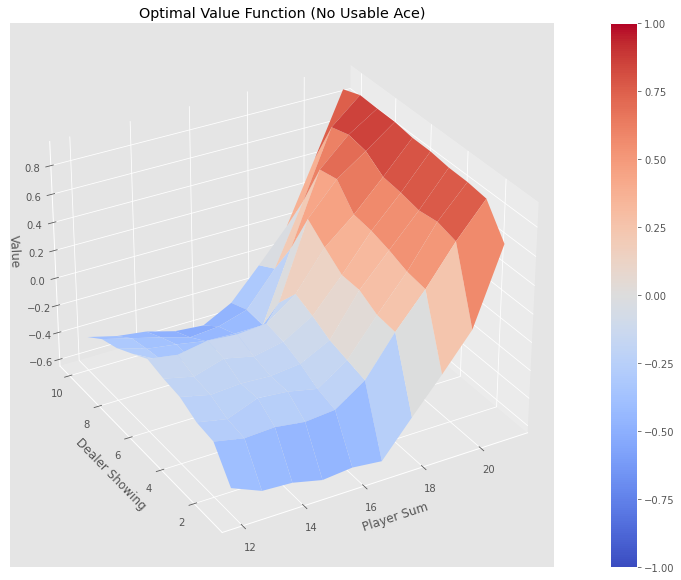

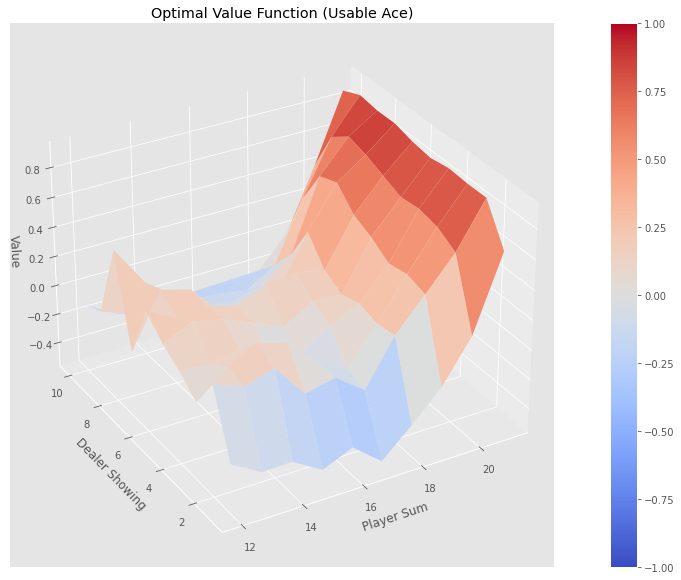

In [60]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")